In [125]:

## Imports
import torch
import sys
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim
import random

## Set styling parameters for figures
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()

## Set random seed for numpy and Torch
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

Check CUDA is available

In [2]:
torch.cuda.is_available()

True

In [3]:
class CoronaVirusPredictor(nn.Module):

    def __init__(self, n_features, n_hidden, seq_len, n_layers=2, ignore_zero=True):
        super(CoronaVirusPredictor, self).__init__()

        if torch.cuda.is_available():
            device = torch.device("cuda:0")
            print("Running on the GPU")
        else:
            device = torch.device("cpu")
            print("Running on CPU")

        self.n_hidden = n_hidden
        self.seq_len = seq_len
        self.n_layers = n_layers

        self.lstm = nn.LSTM(
          input_size=n_features,
          hidden_size=n_hidden,
          num_layers=n_layers,
          dropout=0.5)


        self.linear1 = nn.Linear(in_features=n_hidden, out_features=256)
        self.linear2 = nn.Linear(in_features=256, out_features=512)
        self.linear3 = nn.Linear(in_features=512, out_features=1024)
        self.linear4 = nn.Linear(in_features=1024, out_features=1)

        #self.linear5 = nn.Linear(in_features=10000, out_features=10000)
        #self.linear6 = nn.Linear(in_features=10000, out_features=1)

        


    
    
    def reset_hidden_state(self):
        self.hidden = (
            torch.zeros(self.n_layers, self.seq_len, self.n_hidden).to(device),
            torch.zeros(self.n_layers, self.seq_len, self.n_hidden).to(device)
        )

    def forward(self, sequences):
        lstm_out, self.hidden = self.lstm(sequences.view(len(sequences), self.seq_len, -1),self.hidden)
        last_time_step = lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
        y_pred = self.linear1(last_time_step)
        y_pred = self.linear2(y_pred)
        y_pred = self.linear3(y_pred)
        y_pred = self.linear4(y_pred)
        #y_pred = self.linear5(y_pred)
        #y_pred = self.linear6(y_pred)



        return y_pred

In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on CPU")

Running on the GPU


In [5]:
def train_model(model):
   
    loss_fn = torch.nn.MSELoss(reduction='mean')

    optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)#0.0007
        
    num_epochs =600 #600

    train_hist = np.zeros(num_epochs)
    test_hist = np.zeros(num_epochs)
    
              
    model = model.to(device)
    
    #for i in range(1): #1
        
#         for j in range(len(batches)): 
#             print("\n Epoch:", i, "Batch num:", j, '\n')
#             train_data, train_labels, test_data, test_labels = get_batches(j)       


    for t in range(num_epochs):


        for j in range(4):#(len(batches)):
            
            
            train_data, train_labels, test_data, test_labels = get_batches(j)


            if t % 10 == 0:
                model.reset_hidden_state() # Requiered because he hiddent state was forgetting too early. 

            y_pred = model(train_data)

            loss = loss_fn(y_pred.float(), train_labels)


            if test_data is not None:
                with torch.no_grad():
                    y_test_pred = model(train_data)
                    test_loss = loss_fn(y_test_pred.float(), train_labels)
                test_hist[t] = test_loss.item()

                if t % 10 == 0:  
                    print(f'Epoch {t} train loss: {loss.item()} test loss: {test_loss.item()}')
            elif t % 10 == 0:
                  print(f'Epoch {t} train loss: {loss.item()}')

            train_hist[t] = loss.item()

            optimizer.zero_grad()

            loss.backward()
            optimizer.step()




    return model.eval(), train_hist, test_hist, optimizer, t, loss_fn

In [126]:
data = pd.read_csv("/home/ur10pc/Desktop/robot_data2/80k_data/mean_force_data.csv")
#data = data[:80000]
main_seq = data


In [127]:
n=1000
batchesx = [data[i:i + n] for i in range(0, len(data), n)]
print(len(batchesx))

random.seed(42)
random.shuffle(batchesx)

########################
high_force_list = []
sub_list = [4,6,7,13,17,20,21,29,40,49,57,62,66,70,72,73,74]
for i in sub_list:
    high_force_list.append(batchesx[i])



batches = batchesx[:20]
val_batches = batchesx[20:40]
test_batches = batchesx#[:20]
print(len(batches), len(val_batches), len(test_batches))

79
20 20 79


In [154]:
print(len(high_force_list))
print(high_force_list[8])

17
       joint_0   joint_1   joint_2   joint_3   joint_4   joint_5  force_mean
6000  2.344691 -0.687718  1.410442 -2.266129 -1.575441  2.899532    8.735366
6001  2.349918 -0.690067  1.414980 -2.268296 -1.575513  2.896131    8.916561
6002  2.353586 -0.690391  1.415641 -2.268176 -1.575525  2.892119    9.110715
6003  2.354366 -0.690379  1.415868 -2.268044 -1.575585  2.887773    9.315307
6004  2.354282 -0.690379  1.416013 -2.268032 -1.575585  2.883940    9.499408
...        ...       ...       ...       ...       ...       ...         ...
6995  1.813811 -0.482917  0.963120 -2.056550 -1.567617  2.246700    2.637548
6996  1.813799 -0.482917  0.963132 -2.056562 -1.567676  2.246688    2.640042
6997  1.813787 -0.482930  0.963144 -2.056586 -1.567653  2.246711    2.641971
6998  1.813787 -0.482917  0.963156 -2.056562 -1.567629  2.246700    2.643218
6999  1.813811 -0.482905  0.963144 -2.056562 -1.567701  2.246700    2.644597

[1000 rows x 7 columns]


In [8]:
#print(test_batches[1])

In [9]:
featuresscaler2 = batches[0].iloc[:,-1]

x_scaler = MinMaxScaler(feature_range=(-1, 1))

featuresscaler2 = np.asarray(featuresscaler2)
featuresscaler2 = featuresscaler2.reshape(-1,1)
x_scaler = x_scaler.fit(featuresscaler2)

features2 =x_scaler.transform(featuresscaler2)
targets2 = features2[:,-1].reshape(-1,1)

preds2 = targets2

predicted_cases2 = x_scaler.inverse_transform(preds2).reshape(-1,1)

print("original",batches[0].iloc[:5,-1])
print("scaled",targets2[:5])
print("Unscaled",predicted_cases2[:5])

original 49000    2.234716
49001    2.230994
49002    2.228869
49003    2.226343
49004    2.223548
Name: force_mean, dtype: float64
scaled [[-0.43834195]
 [-0.44074578]
 [-0.44211808]
 [-0.44374971]
 [-0.44555487]]
Unscaled [[2.2347157 ]
 [2.23099402]
 [2.22886939]
 [2.22634325]
 [2.22354845]]


In [10]:
def get_test_batch(batch_number):
    
    seq_size = 500

    X_test = []
    
    data = test_batches[batch_number].reset_index(drop=True)
    data= data[:seq_size]

    features = data[['joint_0', 'joint_2', 'joint_4', 'joint_5']]
    features = np.asarray(features)

    targets = data.iloc[:,-1]
    targets = np.asarray(targets)
    targets = targets.reshape(-1,1)
    
    for i in range(len(features)):           
   
        X =(features[:i+1])
        an_array = np.array(X)
        shape = np.shape(X)
        temp = np.zeros((seq_size, 4))
        temp[(seq_size-shape[0]):,:shape[1]] = an_array
        X_test.append(temp)
        y_test = targets

    
    X_test = torch.cuda.FloatTensor(X_test)
    y_test = torch.cuda.FloatTensor(y_test)
    print(data, '\n')
    print( X_test.shape, y_test.shape)
    jim = targets
    return(X_test, y_test, jim)
  

In [11]:
print(get_test_batch(0))

      joint_0   joint_1   joint_2   joint_3   joint_4   joint_5  force_mean
0    1.884678 -1.026276  2.121598 -2.659940 -1.566119  1.763162    2.234716
1    1.883263 -1.027091  2.123219 -2.660933 -1.566131  1.767244    2.230994
2    1.880589 -1.028626  2.126567 -2.662585 -1.566095  1.775085    2.228869
3    1.876715 -1.030663  2.131596 -2.665135 -1.566143  1.786686    2.226343
4    1.871546 -1.033349  2.137718 -2.668607 -1.566119  1.802022    2.223548
..        ...       ...       ...       ...       ...       ...         ...
495  1.404854 -1.169007  2.482123 -2.859930 -1.567042  2.720587    1.804845
496  1.404902 -1.169030  2.481499 -2.859643 -1.567030  2.720611    1.792167
497  1.404914 -1.169007  2.481043 -2.859511 -1.567090  2.720575    1.782137
498  1.404986 -1.168995  2.480779 -2.859331 -1.567066  2.720599    1.772104
499  1.405094 -1.169030  2.480515 -2.859260 -1.567126  2.720563    1.763096

[500 rows x 7 columns] 

torch.Size([500, 500, 4]) torch.Size([500, 1])
(tensor([[[ 0.0

In [12]:
def get_batches(batch_num):  
    
    seq_size = 500

    data = batches[batch_num].reset_index(drop=True)
    data= data[:seq_size]
    ################################################

    X_train = []
    X_test = []

    
    features = data[['joint_0', 'joint_2', 'joint_4', 'joint_5']]
    features = np.asarray(features)

    targets = data.iloc[:,-1]
    targets = np.asarray(targets)
    targets = targets.reshape(-1,1)


    for i in range(len(features)):           
        
        np.random.seed(42)
       
        X =(features[:i+1])
        an_array = np.array(X)
        shape = np.shape(X)
        temp = np.zeros((seq_size, 4))
        temp[(seq_size-shape[0]):,:shape[1]] = an_array
        X_train.append(temp)
        y_train = targets
    
    data = val_batches[0].reset_index(drop=True)
    data= data[:seq_size]

    features = data[['joint_0', 'joint_2', 'joint_4', 'joint_5']]
    features = np.asarray(features)

    targets = data.iloc[:,-1]
    targets = np.asarray(targets)
    targets = targets.reshape(-1,1)
    
    for i in range(len(features)):           
   
        X =(features[:i+1])
        an_array = np.array(X)
        shape = np.shape(X)
        temp = np.zeros((seq_size, 4))
        temp[(seq_size-shape[0]):,:shape[1]] = an_array
        X_test.append(temp)
        y_test = targets

    

    X_train = torch.cuda.FloatTensor(X_train) # Change data to tensors
    y_train = torch.cuda.FloatTensor(y_train)
    X_test = torch.cuda.FloatTensor(X_test)
    y_test = torch.cuda.FloatTensor(y_test)
    
    #del targets, features, data, temp, an_array
    
    #print(data)
    #print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
    return(X_train, y_train, X_test, y_test)

In [13]:
print(get_batches(0))

(tensor([[[ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 1.8847,  2.1216, -1.5661,  1.7632]],

        [[ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 1.8847,  2.1216, -1.5661,  1.7632],
         [ 1.8833,  2.1232, -1.5661,  1.7672]],

        [[ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         ...,
         [ 1.8847,  2.1216, -1.5661,  1.7632],
         [ 1.8833,  2.1232, -1.5661,  1.7672],
         [ 1.8806,  2.1266, -1.5661,  1.7751]],

        ...,

        [[ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000

In [14]:
seq_length = 500 # when using zero padding, this seq_length is a bit redundent but still has to match the zero's size.

model = CoronaVirusPredictor(
      n_features=4, 
      n_hidden=64, 
      seq_len=seq_length, 
      n_layers=2
    )

model, train_hist, test_hist, optimizer, epochs, loss = train_model(model)

Running on the GPU
Epoch 0 train loss: 9.019170761108398 test loss: 9.019359588623047
Epoch 0 train loss: 18.839805603027344 test loss: 18.839740753173828
Epoch 0 train loss: 2.1155004501342773 test loss: 2.1155917644500732
Epoch 0 train loss: 6.766349792480469 test loss: 6.765451431274414
Epoch 10 train loss: 0.2046739012002945 test loss: 0.20448538661003113
Epoch 10 train loss: 2.2336513996124268 test loss: 2.2327446937561035
Epoch 10 train loss: 0.4891231954097748 test loss: 0.514320433139801
Epoch 10 train loss: 2.3176708221435547 test loss: 2.307577610015869
Epoch 20 train loss: 0.30935272574424744 test loss: 0.29942116141319275
Epoch 20 train loss: 1.3489428758621216 test loss: 1.3332607746124268
Epoch 20 train loss: 0.4066638648509979 test loss: 0.4260982275009155
Epoch 20 train loss: 2.3677031993865967 test loss: 2.3700640201568604
Epoch 30 train loss: 0.3791924715042114 test loss: 0.3866767883300781
Epoch 30 train loss: 1.0640523433685303 test loss: 1.069915533065796
Epoch 30 

Epoch 290 train loss: 0.23977002501487732 test loss: 0.23370273411273956
Epoch 290 train loss: 0.24171501398086548 test loss: 0.23921480774879456
Epoch 290 train loss: 0.25819098949432373 test loss: 0.2658575475215912
Epoch 290 train loss: 2.1993980407714844 test loss: 2.236062526702881
Epoch 300 train loss: 0.258663535118103 test loss: 0.26148685812950134
Epoch 300 train loss: 0.20931251347064972 test loss: 0.20570172369480133
Epoch 300 train loss: 0.29176202416419983 test loss: 0.296345978975296
Epoch 300 train loss: 2.137310266494751 test loss: 2.1485142707824707
Epoch 310 train loss: 0.2881515622138977 test loss: 0.2907573878765106
Epoch 310 train loss: 0.19835413992404938 test loss: 0.19068723917007446
Epoch 310 train loss: 0.3082408607006073 test loss: 0.30676889419555664
Epoch 310 train loss: 2.0610461235046387 test loss: 2.049142837524414
Epoch 320 train loss: 0.36358872056007385 test loss: 0.366506963968277
Epoch 320 train loss: 0.15021266043186188 test loss: 0.159284248948097

Epoch 570 train loss: 0.20217357575893402 test loss: 0.18954452872276306
Epoch 580 train loss: 0.0801267921924591 test loss: 0.0788799598813057
Epoch 580 train loss: 0.06312287598848343 test loss: 0.04812343791127205
Epoch 580 train loss: 0.09679648280143738 test loss: 0.09688225388526917
Epoch 580 train loss: 0.2612173557281494 test loss: 0.24918736517429352
Epoch 590 train loss: 0.09384425729513168 test loss: 0.09251335263252258
Epoch 590 train loss: 0.07471716403961182 test loss: 0.0668872594833374
Epoch 590 train loss: 0.09142259508371353 test loss: 0.09237981587648392
Epoch 590 train loss: 0.19202661514282227 test loss: 0.19637848436832428


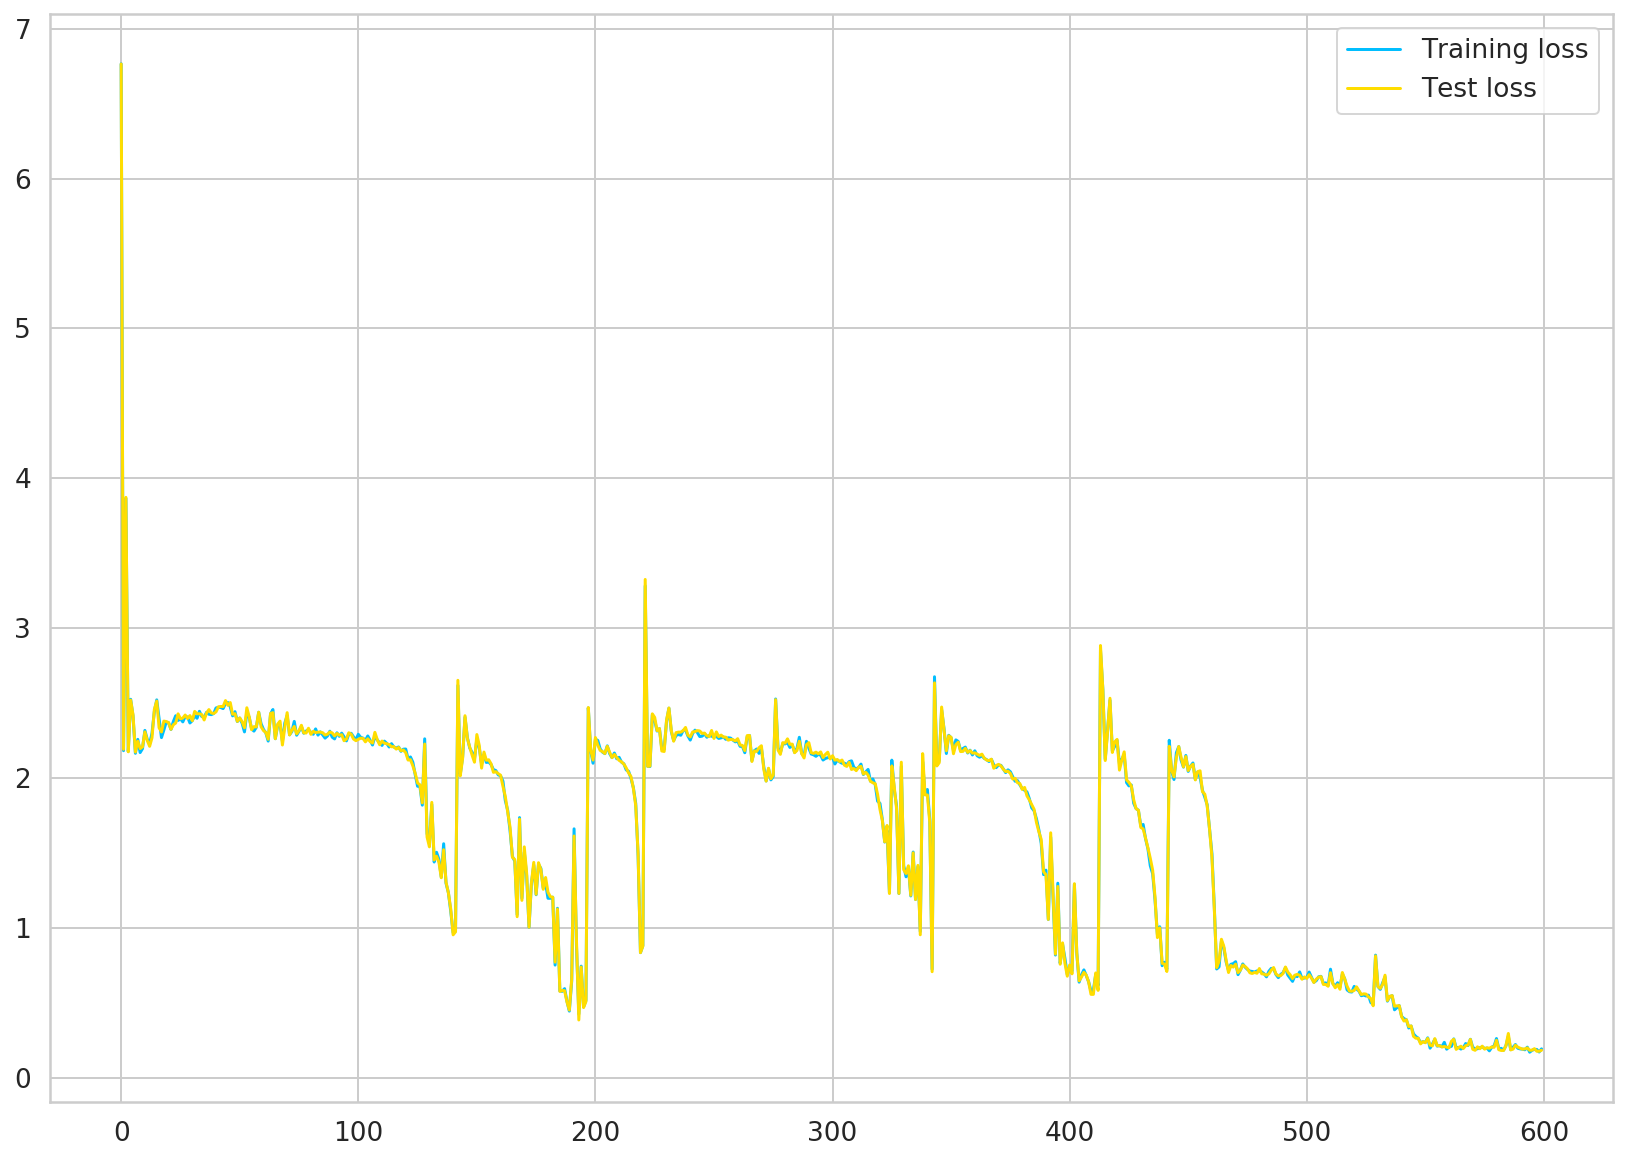

In [15]:
plt.plot(train_hist, label="Training loss")
plt.plot(test_hist, label="Test loss")
#plt.ylim((0, 5))
plt.legend();

RL Controller Predictor

In [16]:
# print(Xtest[0].shape)
# print(Xtest[0])
# seq = Xtest[22].reshape(-1,500,4) #For a given move,
# pred = model(seq).to(device) # send to model and get force prediction.
# print(pred)

NameError: name 'Xtest' is not defined

In [29]:

Xtest, ytest, jim = get_test_batch(0)
model.eval()
with torch.no_grad():
    

    test_seq = Xtest[0].reshape(-1,500,4)#.reshape(1,200,4) # input first sequence from trajectory/batch
    preds = [] # create a list to store predictions.
    for i in range(len(Xtest)-1): # for each sequence i in the trajectory,
        y_test_pred = model(test_seq).to(device) # send sequence to model,
        pred = torch.flatten(y_test_pred).item() # reshape the model output,
        
        preds.append(pred) # and append to the list of predictions - preds.
        new_seq = Xtest[i+1].reshape(-1,500,4)#.reshape(1,200,4) # Change sequence to the next one in the list.
        #print(test_seq, pred, '\n')
        test_seq = torch.cuda.FloatTensor(new_seq).view(1, seq_length, -1) # change sequence to a torch Tensor
        

RuntimeError: CUDA error: unspecified launch failure

In [ ]:
#print(Xtest[0])

In [123]:
# preds = np.asarray(preds)
# preds = np.reshape(preds, (-1,1))

# ytest2 = ytest.cpu()
# ytest2 = np.asarray(ytest2)
# ytest2 = np.reshape(ytest2, (-1,1))

# predicted_cases = preds
# true_cases = ytest2


# preds = np.asarray(preds)
# preds = np.reshape(preds, (-1,1))

# ytest2 = ytest.cpu()
# ytest2 = np.asarray(ytest2)
# ytest2 = np.reshape(ytest2, (-1,1))

# predicted_cases = preds
# true_cases = ytest2


# print(main_seq.shape)
# seq = pd.DataFrame(jim)
# seq = seq.reset_index(drop=True)
#main_seq_reset = main_seq.reset_index(drop=True)

# plt.plot(seq,label='Sequence')

# print(len(predicted_cases))
# plt.plot( true_cases[:,-1], label='Real Force')

# plt.plot(predicted_cases[:,-1], label='Predicted Force')



bob = (test_batches[79].reset_index(drop=True))
print(bob.shape)
plt.plot(bob.iloc[:500,-1])
plt.legend();




IndexError: list index out of range

In [ ]:
plt.plot(batches[0])

In [ ]:
scaler = MinMaxScaler(feature_range=(-1, 1))

scaler = scaler.fit(data)

all_data = scaler.transform(data)

all_data.shape

In [ ]:
tX_all, y_all = train_create_sequences( seq_length)

X_all = torch.cuda.FloatTensor(X_all)
y_all = torch.cuda.FloatTensor(y_all)

model = CoronaVirusPredictor(
  n_features=7, 
  n_hidden=512, 
  seq_len=seq_length, 
  n_layers=2
)
model, train_hist, _ = train_model(model, X_all, y_all)

In [ ]:
DAYS_TO_PREDICT = 5

with torch.no_grad():
    test_seq = X_all[:1]
    preds = []
    for _ in range(DAYS_TO_PREDICT):
    
        y_test_pred = model(test_seq).to(device)
        pred = torch.flatten(y_test_pred).item()
        preds.append(pred)
        print(pred)
        new_seq = test_seq.cpu().numpy().flatten()
        new_seq = np.append(new_seq, [pred])
        new_seq = new_seq[1:]
        test_seq = torch.cuda.FloatTensor(new_seq).view(1, seq_length, -1)
        

In [ ]:
predicted_cases = scaler.inverse_transform(preds).flatten()
print(predicted_cases.shape)
                                           
# print(np.shape(preds))
# preds = np.asarray(preds)
# preds = preds.reshape([5,7])
# print(np.shape(preds))

# predicted_cases = scaler.inverse_transform(preds)                                           

In [ ]:
plt.plot(daily_cases, label='Historical Daily Cases')
plt.plot(predicted_cases, label='Predicted Daily Cases')
plt.legend();

